# 5. Training an Anomaly Detection Model for Covid Anomaly Detection

## Overview

In this tutorial, we will train an anomaly detection model using a simple [LSTM-AutoEncoder model](https://www.medrxiv.org/content/10.1101/2021.01.08.21249474v1).
Data can be obtained from [this link](https://iscteiul365-my.sharepoint.com/:u:/g/personal/oonia_iscte-iul_pt/ERZLm1ruUNpMqkSwjpqhE9wB_7loVWAC4yZWuIH2RKGOlQ?e=kD4HlI). This is a processed version of data from original Stanford dataset-Phase 2. The overall pre-processing pipeline used is illustrated in Figure below.

![preprocessing](stanford_data_processing.png)

Data was aquired from diferent sources (Germin, FitBit, Apple Watch) and pre-processed to have a common format. In this form, data has two columns: heart rate and number of user steps in last minute. 

The processing pipeline is then applied to the data. The pipeline is composed of the following steps:
1. Once data was standardized, the resting heart rate was extracted (``Resting Heart Rate Extractor``, in Figure). This process takes as input `min_minutes_rest` that is the number of minutes that the user has to be at rest to consider the heart rate as resting. `min_minutes_rest` variable looks at user steps and, when user steps is 0 for `min_minutes_rest` minutes, the heart rate is considered as resting. At the end of this process, we will have a new dataframe with: the date (`datetime` column) and the resting heart rate of the last minute (`RHR` column).

2. The smoother process is applied to the data (`Smoother`, in Figure). This process takes as input `smooth_window_sample` that is the number of samples that we will use to smooth the data, and `sample_rate` that is the sample rate. The smoother process will apply a moving average filter to the data, with a window of `smooth_window_sample` samples. Then the data is downsampled to `sample_rate` samples per minute. This process will produce a new dataframe with the date (`datetime` column), the resting heart rate at desired sampling rate (`RHR` column).

3. The second step is adding labels (`Label Adder`, in Figure). Is is also illustrated in Figure below. This process takes 3 inputs: `baseline_days`, `before_onset`, and `after_onset`. The `baseline_days` is the number of days before the onset of the symptoms that we consider as baseline (in figure below, this is 21 days). Thus, using the dataframe from last step, a new column named `baseline` is added, which is a boolean column that is True if the date is in the baseline period (21 days before onset). The `before_onset` and `after_onset` are the number of days before and after the onset of the symptoms that we consider as the anomaly period (7 days before and 21 days before, in Figure below). A new column named `anomaly` is added, which is a boolean column that is True if the date is in the anomaly period. Finnaly, we also add a `status` column,that is a metadata column for a descriptive status of the date. If can be: 
   - `normal`: if the date is in the baseline period; 
   - `before onset`: if the date is in the period before the onset of the symptoms; 
   - `onset` if the date is the onset of the symptoms (day); 
   - `after onset` if the date is in the period after the onset of the symptoms, but before the recovery; 
   - `recovered` if the date is in the recovery period.

4. Once the labels were added we normalize the data (`Standardizer` in Figure above). This process perform a Z-norm scale on the data. The Z-norm scale is calculated as: $z = \frac{x - \mu}{\sigma}$, where $x$ is the value, $\mu$ is the mean of the column and $\sigma$ is the standard deviation of the column. An important note here is that the mean and standard deviation are calculated only for the baseline period, and then applied to the entire dataset.

5. The last step is to create the sequences (`Transposer`, in Figure), that will group $n$ rows and transform it into columns (features). This process takes as input `window_size` and `overlap` parameters and creates sequences of `window_size` samples with an overlap of `overlap` samples. Thus, if we have a dataset with 100 samples, a `window_size` of 20 and an `overlap` of 0, we will have 5 sequences of 20 samples each (*i.e.* 5 rows with 20 columns). Each element of the sequence will be a column in the dataframe, numbered from 0 to 19. Thus, for example, the sequences will have columns `RHR-0`, `RHR-1`, ..., `RHR-19`, where the first row is the first 20 samples, the second row is the second 20 samples, and so on. This is useful as it is the format that the LSTM-AutoEncoder model expects as input. An important note is that we do not mix sequences from anomaly and non-anomaly periods. Thus, no label is mixed, that is, an anomaly sample only has anomaly time-steps.

This will produce a dataframe (CSV file) for each user. In processed dataset, we joined all users in a single file and add a column `participant_id` to identify the user. This makes easier to work with the data in the next steps.

![labeling](anomaly_periods.png)

We already generated several files, with different parameters and operations of the pre-processing pipeline:
* `rhr_df`: dataframe with the resting heart rate without normalization (step 4) and transposing (step 5). The `min_minutes_rest` is 12, `smooth_window_sample` is 400, `sample_rate` is 1 hour, `baseline_days` is 21, `before_onset` is 7, and  `after_onset` is 21.
* `rhr_df_scaled`: same as `rhr_df`, but with normalization.
* `windowed_16_overlap_0_rate_10min_df`: same dataframe as `rhr_df` with the resting heart rate normalized (step 4) and transposed (step 5). The `window_size` is 16, `overlap` is 0, and `sample_rate` is 10 minutes.
* `windowed_16_overlap_0_rate_10min_scaled_df`: same dataframe as `windowed_16_overlap_0_rate_10min_df`, but with normalization.

**NOTE**: The files follows this naming convention: `windowed_{window_size}_overlap_{overlap}_rate_{sample_rate}_df.csv`. If sample_rate is ommited, it is, by default 1 hour.
**NOTE**: The files may and with `fold_X`, where `X` is the fold number. This is used for cross-validation purposes.

## Training

Let's import some libraries

In [1]:
import pandas as pd
from ssl_tools.data.data_modules.covid_anomaly import CovidUserAnomalyDataModule
from ssl_tools.models.nets.lstm_ae import LSTMAutoencoder
import lightning as L
import torch
import numpy as np
from torchmetrics import MeanSquaredError
from sklearn.metrics import f1_score, recall_score, balanced_accuracy_score, roc_auc_score
import numpy as np
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

Load data and inspect

In [2]:
# Read CSV data
data_path = "/workspaces/AIMH-Dev-Container/shared_data/stanford_phase2_processed_data/windowed_16_overlap_8_df_scaled.csv"
df = pd.read_csv(data_path)
df

,datetime,RHR-0,RHR-1,RHR-2,RHR-3,RHR-4,RHR-5,RHR-6,RHR-7,RHR-8,...,RHR-10,RHR-11,RHR-12,RHR-13,RHR-14,RHR-15,anomaly,baseline,label,participant_id
0,2027-01-14 21:00:00,1.170175,0.653752,-0.392374,-1.431553,-2.129013,-2.755962,-3.681322,-4.674443,-5.668570,...,-6.937363,-7.102118,-6.975790,-6.554774,-6.112156,-5.396099,False,True,normal,P110465
1,2027-01-15 05:00:00,-5.668570,-6.373289,-6.937363,-7.102118,-6.975790,-6.554774,-6.112156,-5.396099,-4.415848,...,-2.656756,-1.305630,-0.072756,1.046195,1.530467,1.829053,False,False,normal,P110465
2,2027-01-15 13:00:00,-4.415848,-3.467073,-2.656756,-1.305630,-0.072756,1.046195,1.530467,1.829053,1.223064,...,-0.424000,-1.145581,-1.355121,-2.321206,-3.124961,-3.928738,False,False,normal,P110465
3,2027-01-15 21:00:00,1.223064,0.472444,-0.424000,-1.145581,-1.355121,-2.321206,-3.124961,-3.928738,-4.802627,...,-6.067744,-5.460156,-4.671143,-3.408943,-2.237883,-1.187843,False,False,normal,P110465
4,2027-01-16 05:00:00,-4.802627,-5.831013,-6.067744,-5.460156,-4.671143,-3.408943,-2.237883,-1.187843,-0.062360,...,2.266944,3.794465,4.625745,4.827756,4.720000,4.677464,False,False,normal,P110465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31732,2024-12-13 00:00:00,-0.180702,-0.499793,-0.749829,-0.868485,-0.966754,-1.004670,-0.888210,-0.580762,-0.467943,...,0.092000,0.347840,0.636395,0.958195,1.170514,1.301841,False,False,recovered,P992022
31733,2024-12-13 08:00:00,-0.467943,-0.162740,0.092000,0.347840,0.636395,0.958195,1.170514,1.301841,1.477526,...,1.660344,1.656600,1.685652,1.747252,1.767329,1.793616,False,False,recovered,P992022
31734,2024-12-13 16:00:00,1.477526,1.657321,1.660344,1.656600,1.685652,1.747252,1.767329,1.793616,1.728615,...,1.509833,1.380749,1.263744,1.139997,1.024205,0.946663,False,False,recovered,P992022
31735,2024-12-14 00:00:00,1.728615,1.616265,1.509833,1.380749,1.263744,1.139997,1.024205,0.946663,1.136868,...,1.642153,1.909381,2.114439,2.282238,2.453691,2.587843,False,False,recovered,P992022


In [3]:
# Print all participants
df.participant_id.unique()

array(['P110465', 'P111019', 'P148618', 'P182427', 'P203215', 'P206998',
       'P209134', 'P214671', 'P219295', 'P219455', 'P230742', 'P249349',
       'P256033', 'P259158', 'P261190', 'P262255', 'P271946', 'P277912',
       'P279697', 'P292181', 'P305571', 'P308755', 'P310300', 'P319777',
       'P320539', 'P323003', 'P328945', 'P330232', 'P333074', 'P355472',
       'P389953', 'P395188', 'P401732', 'P426746', 'P430757', 'P442730',
       'P469946', 'P476443', 'P476514', 'P477816', 'P500432', 'P508925',
       'P511540', 'P516467', 'P530788', 'P533807', 'P542912', 'P543995',
       'P549078', 'P584112', 'P608324', 'P612886', 'P625831', 'P631814',
       'P635568', 'P662021', 'P662924', 'P682517', 'P693795', 'P706971',
       'P708653', 'P723676', 'P723961', 'P726139', 'P741171', 'P749288',
       'P754260', 'P759795', 'P760409', 'P763925', 'P819867', 'P839431',
       'P851598', 'P885171', 'P885343', 'P954010', 'P992022'],
      dtype=object)

Creating a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html).
* The first parameter is the path to the CSV file.
* `participants`: is a list of participants to include in dataset. If nothing is passed, all participants in CSV are included.
* `batch_size`: is the batch size to use in the dataloader.
* `num_workers`: is the number of workers to use in the dataloader.
* `reshape`: is the shape of the input data. For LSTM-AutoEncoder, it is `(sequence_length, num_features)`, or, in our case `(16, 1)`

**NOTE**: The training data is only data where baseline is True. The test data will be only data where baseline is False.

In [4]:
dm = CovidUserAnomalyDataModule(
    data_path,
    participants=["P262255"],
    batch_size=32,
    num_workers=0,
    reshape=(16, 1),
)
dm

CovidUserAnomalyDataModule (Data=/workspaces/AIMH-Dev-Container/shared_data/stanford_phase2_processed_data/windowed_16_overlap_8_df_scaled.csv, 1 participant selected)

Let's create the lightning model

In [5]:
model = LSTMAutoencoder(input_shape=(16, 1))
model

LSTMAutoencoder(
  (backbone): _LSTMAutoEncoder(
    (lstm1): LSTM(1, 128, batch_first=True)
    (lstm2): LSTM(128, 64, batch_first=True)
    (repeat_vector): Linear(in_features=64, out_features=1024, bias=True)
    (lstm3): LSTM(64, 64, batch_first=True)
    (lstm4): LSTM(64, 128, batch_first=True)
    (time_distributed): Linear(in_features=128, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)

Creting Trainer

In [6]:
# We disable the checkpointing for this example
trainer = L.Trainer(max_epochs=100, devices=1, accelerator="gpu", enable_checkpointing=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fit the model using training data from the datamodule

In [7]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | _LSTMAutoEncoder | 316 K  | train
1 | loss_fn  | MSELoss          | 0      | train
------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.264     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## Predicting

In [8]:
def compute_losses(y, y_pred, loss_fn):
    losses = []
    for _y, _y_pred in zip(y, y_pred):
        loss = loss_fn(_y, _y_pred)
        loss = loss.detach().numpy().item()
        losses.append(loss)
    return losses

In [9]:
dm.setup("fit")
train_dataset = dm.train_dataloader().dataset

dm.setup("test")
test_dataset = dm.test_dataloader().dataset

### Defining Anomaly Threshold

The anomaly threshold is defined as the maximum reconstruction error in the training data. Other approaches can be used, such as using a quantile of the reconstruction error, but for simplicity, we will use the maximum reconstruction error.

In [10]:
# Make some predictions!

x_train = torch.stack([torch.Tensor(x) for x, y in train_dataset])
y_train = np.array([y for x, y in train_dataset])
x_train_hat = model(x_train)

In [11]:
# Calculate the MSE loss for each sample and use the maximum as the anomaly threshold
mse = MeanSquaredError()
losses = compute_losses(x_train, x_train_hat, mse)

anomaly_threshold = max(losses)
anomaly_threshold

0.7750090956687927

### Predicting on Test set

Now, let's predict on the test set. We will use the test data from the datamodule and calculate the reconstruction error for each sample. Samples with reconstruction error above the threshold are considered anomalies, otherwise, they are normal.

In [12]:
# Predict on the test dataset
x_test = torch.stack([torch.Tensor(x) for x, y in test_dataset])
y_test = np.array([y for x, y in test_dataset])

x_test_hat = model(x_test)

In [13]:
# Calculate the MSE loss for each sample
mse = MeanSquaredError()
losses = compute_losses(x_test, x_test_hat, mse)

y_test_hat = [1 if loss > anomaly_threshold else 0 for loss in losses]

Let's put all together (true and predicteds) just for sake of simplicity and visualization

In [14]:
results_dataframe = pd.DataFrame(
    {
        "true": y_test,
        "predicted": y_test_hat,
        "loss": losses,
        "anomaly_threshold": anomaly_threshold,
    }
)

results_dataframe

,true,predicted,loss,anomaly_threshold
0,0,0,0.270930,0.775009
1,0,0,0.402659,0.775009
2,0,0,0.772812,0.775009
3,0,1,1.044425,0.775009
4,0,1,1.087600,0.775009
5,0,1,0.981782,0.775009
6,0,0,0.580925,0.775009
7,0,0,0.044288,0.775009
8,0,0,0.114536,0.775009
9,0,0,0.182375,0.775009


### Visualizing Metrics and Confusion Matrix

Let's calculate some metrics

In [15]:
# Extract true and predicted labels from the results_dataframe
true_labels = results_dataframe['true']
predicted_labels = results_dataframe['predicted']

# Calculate the F1-score
f1 = f1_score(true_labels, predicted_labels)

# Calculate the recall
recall = recall_score(true_labels, predicted_labels)

# Calculate the balanced accuracy
balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

# Calculate the ROC AUC
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Print the results
print("F1-score:", f1)
print("Recall:", recall)
print("Balanced Accuracy:", balanced_acc)
print("ROC AUC:", roc_auc)

F1-score: 0.5
Recall: 0.42857142857142855
Balanced Accuracy: 0.5714285714285714
ROC AUC: 0.5714285714285714


And visualize the Confusion Matrix

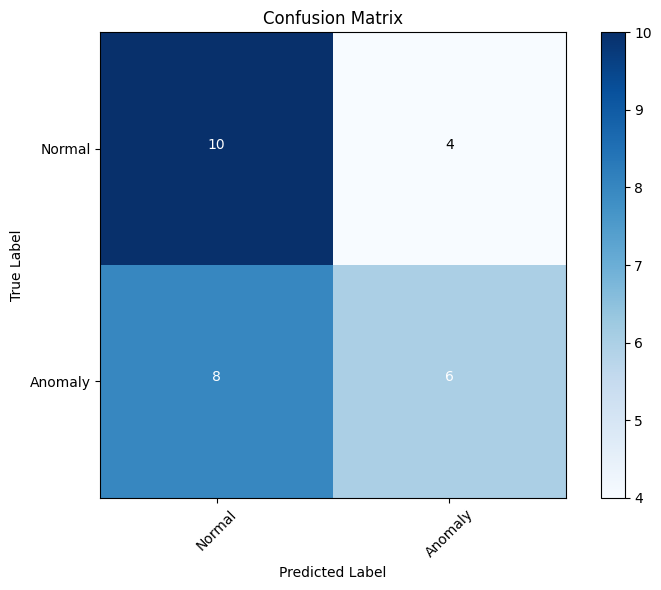

In [16]:
# Get the true and predicted labels from the results_dataframe
true_labels = results_dataframe['true']
predicted_labels = results_dataframe['predicted']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define the class labels
class_labels = ['Normal', 'Anomaly']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the values to the confusion matrix plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()